In [116]:
import pystencils as ps
import numpy as np
import sympy as sp
from pystencils import plot as plt
import psutil
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
import matplotlib.animation as animation
from pystencils.boundaries import add_neumann_boundary, Neumann, Dirichlet, BoundaryHandling
from pystencils.slicing import slice_from_direction
import math
import time
%matplotlib inline

In [117]:
dh = ps.create_data_handling(domain_size=(256, 1), periodicity=True)  # able to organize data on 256x256 lattice
μ_field = dh.add_array('mu', latex_name='μ', ghost_layers=2)  # chemical potential (functional derivative of free energy)
c_field = dh.add_array('c', ghost_layers=2)  # raw concentration that free energy depends on

In [118]:
ε, q_0, γ = sp.symbols("ε q_0 γ")

c = c_field.center
μ = μ_field.center

def f(c):
    return -ε*c**2/2 + c**4/4

bulk_free_energy_density = f(c)

covariant_free_energy_density = 1/2 * c**2

grad_sq = sum(ps.fd.diff(c, i)**2 for i in range(dh.dim))
interfacial_free_energy_density = -grad_sq

grad_fourth = sum(ps.fd.diff(ps.fd.diff(c, i), i)**2 for i in range(dh.dim)) + 2*ps.fd.diff(ps.fd.diff(c, 0), 0)*ps.fd.diff(ps.fd.diff(c, 1), 1)
interface_deformation_free_energy_density = 1/2 * grad_fourth

free_energy_density = bulk_free_energy_density + covariant_free_energy_density + interfacial_free_energy_density + interface_deformation_free_energy_density
free_energy_density

c_C**4/4 - c_C**2*ε/2 + 0.5*c_C**2 - Diff(c_C, 0, -1)**2 - Diff(c_C, 1, -1)**2 + 0.5*Diff(Diff(c_C, 0, -1), 0, -1)**2 + 1.0*Diff(Diff(c_C, 0, -1), 0, -1)*Diff(Diff(c_C, 1, -1), 1, -1) + 0.5*Diff(Diff(c_C, 1, -1), 1, -1)**2

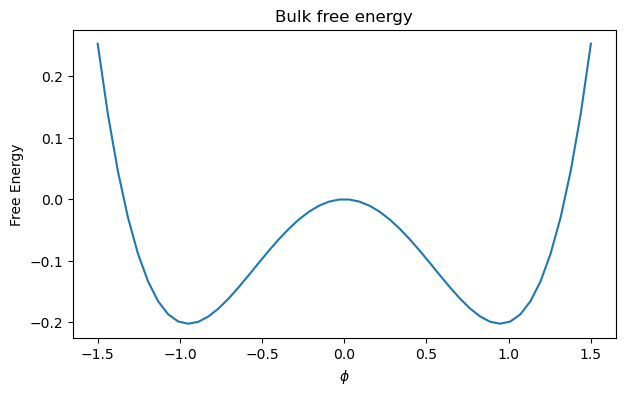

In [119]:
plt.figure(figsize=(7,4))
plt.sympy_function(bulk_free_energy_density.subs(ε, 0.9), (-1.5, 1.5))
plt.xlabel(r"$\phi$")
plt.ylabel("Free Energy")
plt.title("Bulk free energy");
plt.savefig('Symmetrized energy.jpg', dpi = 800)
plt.show()

In [120]:
# here we manually write the update equation for chemical potential μ because 
# Pystencils functional derivative method cannot handle mixed partial derivatives
def bulk_deriv(c):
    return -ε*c + c**3

μ_bulk = bulk_deriv(c)

μ_covariant = c

laplacian = sum(ps.fd.diff(c, i, i) for i in range(dh.dim))
μ_interfacial = 2*laplacian

grad_fourth = sum(ps.fd.diff(c, i, i, i, i) for i in range(dh.dim)) + 2*ps.fd.diff(c, 1, 1, 0, 0)
μ_interface_deformation = grad_fourth

μ_update_eq = μ_bulk + μ_covariant + μ_interfacial + μ_interface_deformation

μ_update_eq

c_C**3 - c_C*ε + c_C + 2*Diff(Diff(c_C, 0, -1), 0, -1) + 2*Diff(Diff(c_C, 1, -1), 1, -1) + Diff(Diff(Diff(Diff(c_C, 0, -1), 0, -1), 0, -1), 0, -1) + 2*Diff(Diff(Diff(Diff(c_C, 0, -1), 0, -1), 1, -1), 1, -1) + Diff(Diff(Diff(Diff(c_C, 1, -1), 1, -1), 1, -1), 1, -1)

In [147]:
'''
It turns out the inbuilt discretization functions neither work for above 2nd order differential equations...
Let's do this part by hand too, and hope it works.
'''
epsilon = 0.9
natural_period = (6*np.pi/(2+np.sqrt(1+3*epsilon)))
one_sixteenth_period = 1/16*natural_period

discretize_2ndorderPDEs = ps.fd.Discretization2ndOrder(dx=one_sixteenth_period, dt=2*10**(-5))

μ_interfacial_discretized = discretize_2ndorderPDEs(μ_interfacial)

μ_interfacial_discretized

-88.7326644009757*c_C + 22.1831661002439*c_E + 22.1831661002439*c_N + 22.1831661002439*c_S + 22.1831661002439*c_W

In [148]:
#we must recursively leverage the in-built function for discretizing 2nd order PDEs in order to discretize our 4th order one
second_grad_0 = ps.fd.diff(c,0,0)
second_grad_1 = ps.fd.diff(c,1,1)

second_grad_0_discretized = discretize_2ndorderPDEs(second_grad_0)
second_grad_1_discretized = discretize_2ndorderPDEs(second_grad_1)

fourth_grad_0 = ps.fd.diff(second_grad_0_discretized,0,0)
fourth_grad_0 = ps.fd.expand_diff_linear(fourth_grad_0)
fourth_grad_1 = ps.fd.diff(second_grad_1_discretized,1,1)
fourth_grad_1 = ps.fd.expand_diff_linear(fourth_grad_1)

fourth_grad_0_discretized = discretize_2ndorderPDEs(fourth_grad_0)
fourth_grad_1_discretized = discretize_2ndorderPDEs(fourth_grad_1)


fourth_grad_mixed = ps.fd.diff(second_grad_0_discretized,1,1)
fourth_grad_mixed = ps.fd.expand_diff_linear(fourth_grad_mixed)


fourth_grad_mixed_discretized = 2*discretize_2ndorderPDEs(fourth_grad_mixed)


μ_interface_deformation_discretized = fourth_grad_0_discretized + fourth_grad_1_discretized + fourth_grad_mixed_discretized
μ_interface_deformation_discretized

123.023214557753*c_2E + 123.023214557753*c_2N + 123.023214557753*c_2S + 123.023214557753*c_2W + 2460.46429115505*c_C - 984.185716462022*c_E - 984.185716462022*c_N + 246.046429115505*c_NE + 246.046429115505*c_NW - 984.185716462022*c_S + 246.046429115505*c_SE + 246.046429115505*c_SW - 984.185716462022*c_W

In [149]:
μ_update_eq_discretized = μ_bulk + μ_covariant + μ_interfacial_discretized + μ_interface_deformation_discretized
μ_update_eq_discretized

123.023214557753*c_2E + 123.023214557753*c_2N + 123.023214557753*c_2S + 123.023214557753*c_2W + c_C**3 - c_C*ε + 2372.73162675408*c_C - 962.002550361778*c_E - 962.002550361778*c_N + 246.046429115505*c_NE + 246.046429115505*c_NW - 962.002550361778*c_S + 246.046429115505*c_SE + 246.046429115505*c_SW - 962.002550361778*c_W

In [150]:

μ_kernel = ps.create_kernel([ps.Assignment(μ_field.center,
                                           μ_update_eq_discretized.subs(ε, epsilon))]
                           ).compile()
# here we define the update function of the chemical potential BEFORE that of yhe concentration

In [151]:
M = sp.Symbol("M")
# after suffering through the defining the dynamics of the chemical potential, 
# we know full dynamics is just the diffusionary Fick's Law of that
conserved_swift_hohenberg = ps.fd.transient(c) - ps.fd.diffusion(μ, M)  # continuity equation! M is mobility (diffusion) coefficient
conserved_swift_hohenberg

-Diffusion(mu_C, M) + Transient(c_C)

In [152]:
# 2nd order discretization of the second derivative, the middle term compounds
c_update = discretize_2ndorderPDEs(conserved_swift_hohenberg) 
c_update  # this is the symbolic rule of how c updates

c_C - 0.000887326644009757*mu_C*M + 0.000221831661002439*mu_E*M + 0.000221831661002439*mu_N*M + 0.000221831661002439*mu_S*M + 0.000221831661002439*mu_W*M

In [153]:
c_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update.subs(M, 1))]
                           ).compile()

In [154]:
dh.ghost_layers_of_field('c')

2

In [155]:
# no boundary functions because periodicity was already set in the data handler
def init(value=0.0, noise=0.02):
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        b['c'].fill(value)
        np.add(b['c'], noise*(np.random.rand(*b['c'].shape)-1/2), out=b['c'])

In [156]:
def init_mixed(phi_uni=-0.675, phi_per=-0.243, frac_per=0.5, noise=0.01):
    #the values here are set default for epsilon = 0.9
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each element
        b['c'].fill(0)
        mixed = np.zeros(b['c'].shape)
        mixed_line = np.full(mixed.shape[0], phi_uni)
        for i in range(int(mixed.shape[0]*frac_per)):
            mixed_line[i] = phi_per
        for i in range(mixed.shape[1]):
            mixed[:,i] = mixed_line
        mixed = np.add(mixed, noise*(np.random.rand(*b['c'].shape)-1/2), out=mixed)
        np.add(b['c'], mixed, out=b['c'])

In [265]:
def init_mixed_preperiod(phi_uni=-0.675, phi_per=-0.243, frac_per=0.5, noise=0.01):
    #the values here are set default for epsilon = 0.9
    for b in dh.iterate(ghost_layers=2):  # iterate() contains each domain! so an entire lattice block is each term of iterate
        b['c'].fill(0)
        mixed = np.zeros(b['c'].shape)
        domain_length = mixed.shape[0]
        mixed_line = np.full(domain_length, phi_uni)
        cell_length = int((domain_length)*frac_per)
        cell_line = np.linspace(-(cell_length/2)*one_sixteenth_period,cell_length/2*one_sixteenth_period,cell_length)
        sinusoid = 1/10*np.cos(2*np.pi/natural_period*cell_line)
        cell_line = sinusoid + phi_per - np.mean(sinusoid)
        for i in range(cell_length):
            mixed_line[i+int((domain_length - cell_length)/2)] = cell_line[i]
        for i in range(mixed.shape[1]):
            mixed[:,i] = mixed_line
        mixed = np.add(mixed, noise*(np.random.rand(*b['c'].shape)-1/2), out=mixed)
        print(np.mean(mixed[2:-2,2]))
        true_frac_per = frac_per*domain_length/(domain_length-4)
        true_frac_uni = ((1-frac_per)*domain_length-4)/(domain_length-4)
        print('True fraction periodic:', true_frac_per)
        print('True fraction uniform:', true_frac_uni)
        print('Expected avg phi without noise:', (phi_per*true_frac_per+phi_uni*true_frac_uni))
        np.add(b['c'], mixed, out=b['c'])

In [266]:
init_mixed_preperiod(frac_per=0.1)


-0.6310670505678295
True fraction periodic: 0.1015625
True fraction uniform: 0.8984375
Expected avg phi without noise: -0.631125


-0.631069555218283
True fraction periodic: 0.1015625
True fraction uniform: 0.8984375
Expected avg phi without noise: -0.631125
-0.631069555218283


-0.6310695552182826

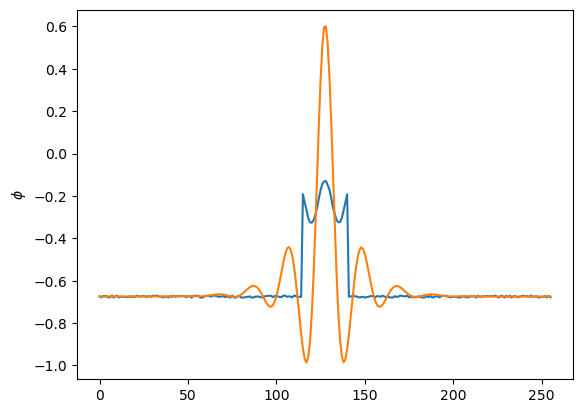

In [267]:
#init()
init_mixed_preperiod(frac_per=0.1)
c_arr = dh.cpu_arrays['c'][2:-2,2]
plt.plot(c_arr)
print(np.mean(c_arr))
timeloop(steps=1000000)
#print(c_arr[:,2])
#plt.hlines(c_arr[0], 0, 256)
plt.plot(c_arr)
plt.ylabel(r'$\phi$')
np.mean(c_arr)

In [172]:
def timeloop(steps=100):
    c_sync = dh.synchronization_function(['c'])
    μ_sync = dh.synchronization_function(['mu'])
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)  # need chemical potential to update first
        μ_sync()
        dh.run_kernel(c_kernel)  # followed by concentration dynamics from the chemical potential
    return dh.gather_array('c')

Sim time:  102.37205429992173
(1000, 257)


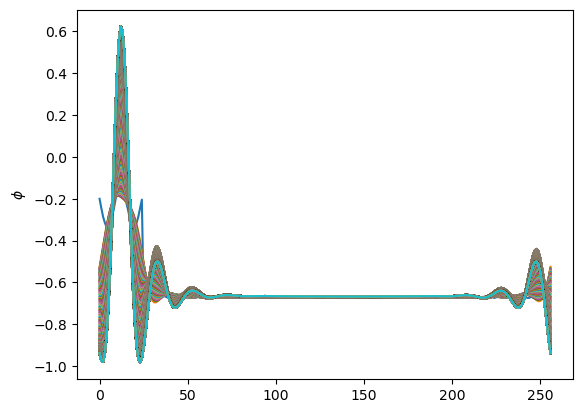

Text(0, 0.5, '$\\phi$')

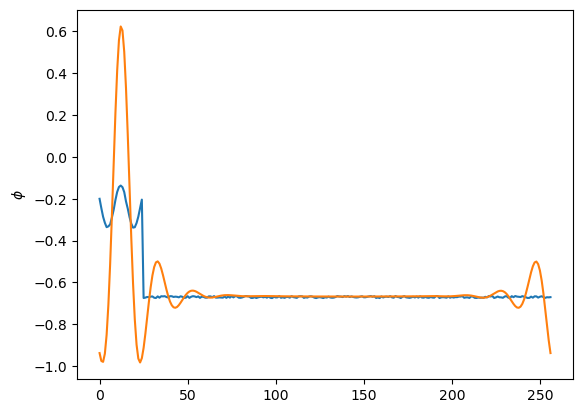

In [166]:
start_time = time.perf_counter()

phi = -0.5
fraction_cells = 0.1
#init(phi,0.01)
#init_mixed(frac_per=fraction_cells)
init_mixed_preperiod(frac_per=fraction_cells)
total_steps = 5000000
total_frames = 1000
c_arrs = np.zeros((total_frames,257))
for i in range(total_frames):
    c_arr = dh.cpu_arrays['c']
    plt.plot(c_arr[1:-2,2])
    c_arrs[i,:] = c_arr[1:-2,2].copy()
    timeloop(steps=int(total_steps/total_frames)) 
    

plt.ylabel(r'$\phi$')
        
end_time = time.perf_counter()        
sim_time = end_time - start_time
print("Sim time: ", sim_time)
print(c_arrs.shape)
plt.show()
plt.plot(c_arrs[0])
plt.plot(c_arrs[total_frames-1])
plt.ylabel(r'$\phi$')



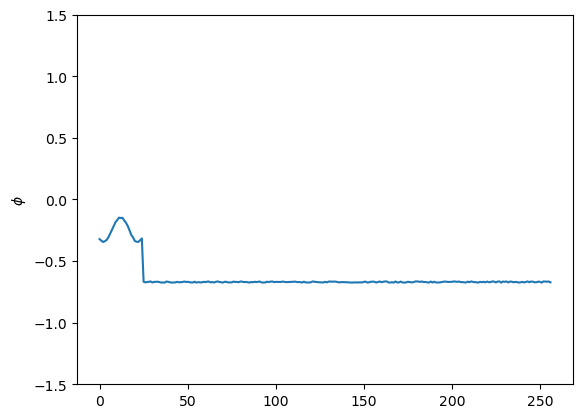

In [93]:
fig,ax = plt.subplots()
line, = ax.plot(np.arange(257),c_arrs[0])
ax.set_ylim(-1.5,1.5)
plt.ylabel(r'$\phi$')

def animate(i):
    line.set_data(np.arange(257),c_arrs[i])

from matplotlib import animation

anim = animation.FuncAnimation(fig, animate, interval=0.05, frames=total_frames-1)

anim.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\1D' + f' eps={epsilon} fraction={np.round(fraction_cells,3)}' + '.mp4', writer=animation.FFMpegWriter(fps=60))

In [59]:
hist, bin_edges = np.histogram(c_arrs[total_frames-1,:], bins=20)

print(hist)

print(bin_edges)

print(c_arrs[total_frames-1,:])

[  9   4   3 161  52  14   2   0   2   0   0   2   0   0   2   0   2   0
   2   2]
[-0.98196279 -0.90225572 -0.82254866 -0.74284159 -0.66313452 -0.58342745
 -0.50372039 -0.42401332 -0.34430625 -0.26459919 -0.18489212 -0.10518505
 -0.02547798  0.05422908  0.13393615  0.21364322  0.29335029  0.37305735
  0.45276442  0.53247149  0.61217855]
[-0.92598415 -0.96943999 -0.98185435 -0.95306497 -0.87475775 -0.74264643
 -0.55890502 -0.33399476 -0.08683729  0.15729814  0.37085277  0.52871222
  0.61217855  0.61142673  0.52654491  0.367526    0.15320613 -0.09121946
 -0.33819107 -0.56251997 -0.74542135 -0.87658683 -0.95397463 -0.98196279
 -0.96891498 -0.92501019 -0.86072061 -0.78591937 -0.70940286 -0.63860275
 -0.57935213 -0.5356763  -0.50965142 -0.50139691 -0.50924847 -0.53011644
 -0.55998763 -0.59449466 -0.62946276 -0.66135408 -0.68755784 -0.7065112
 -0.71766914 -0.72136281 -0.71859281 -0.71079925 -0.69963936 -0.68679216
 -0.67380016 -0.66195232 -0.65220885 -0.64516664 -0.6410622  -0.6398071
 -0.6

(0.0, 170.0)

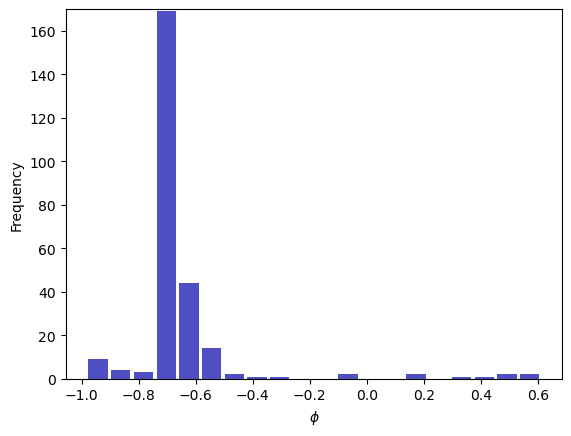

In [45]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=c_arr[1:-2,2], bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel(r'$\phi$')
plt.ylabel('Frequency')
#plt.title('Phi Values in Mixed State')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# Let's add growth!!

### By adding growth in the same notebook, we can immediately start growing from a relaxed steady state. Most notably from a relaxed state of a single (layer of) cell.

In [94]:
#here we define the growth term and a new growth dynamical equation

g, M, W, C, S = sp.symbols("g M W C S")

def growth_term(c):
    return g*(sp.tanh(S*(c + W/2 - C))*sp.tanh(S*(W/2 + C - c)) + 1)

c_growth = growth_term(c)
# after suffering through defining the dynamics of the chemical potential, 
# we know full dynamics is just the diffusionary Fick's Law of that + our proposed growth term
swift_hohenberg_growth = ps.fd.transient(c) - ps.fd.diffusion(μ, M) - c_growth  # continuity equation! M is mobility (diffusion) coefficient
swift_hohenberg_growth



-g*(tanh(S*(-c_C + C + W/2))*tanh(S*(c_C - C + W/2)) + 1) - Diffusion(mu_C, M) + Transient(c_C)

In [95]:
# 2nd order discretization of the second derivative, the middle term compounds
c_update_growth= discretize_2ndorderPDEs(swift_hohenberg_growth) 
c_update_growth  # this is the symbolic rule of how c updates

c_C - 0.000887326644009757*mu_C*M + 0.000221831661002439*mu_E*M + 0.000221831661002439*mu_N*M + 0.000221831661002439*mu_S*M + 0.000221831661002439*mu_W*M + 2.0e-5*g*tanh(S*(-2*c_C + 2*C + W)/2)*tanh(S*(2*c_C - 2*C + W)/2) + 2.0e-5*g

In [101]:
mobility=1
growth_factor=0.05
sigmoid=20
width=np.sqrt(epsilon)*9/10
center=np.sqrt(epsilon)/2

c_growth_kernel = ps.create_kernel([ps.Assignment(c_field.center,
                                           c_update_growth.subs(M, mobility).subs(g,growth_factor).subs(S,sigmoid).subs(W,width).subs(C,center))]
                           ).compile()

def timeloop_growth(steps=100):
    c_sync = dh.synchronization_function(['c'])
    μ_sync = dh.synchronization_function(['mu'])
    for t in range(steps):
        c_sync()
        dh.run_kernel(μ_kernel)  # need chemical potential to update first
        μ_sync()
        dh.run_kernel(c_growth_kernel)  # followed by concentration dynamics from the chemical potential, which now grow too
    return dh.gather_array('c')

Sim time:  313.12407439999515
(1000, 257)


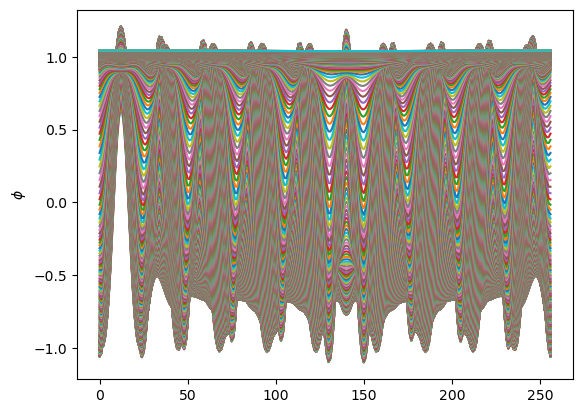

Text(0, 0.5, '$\\phi$')

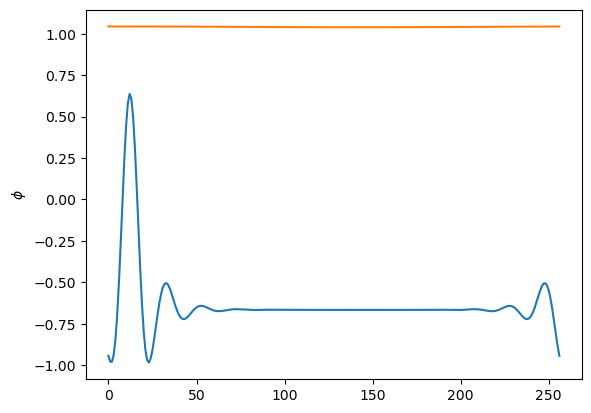

In [102]:
start_time = time.perf_counter()

phi = -0.5
fraction_cells = 0.1
#init(phi,0.01)
#init_mixed(frac_per=fraction_cells)
total_steps = 10000000
total_frames = 1000
c_arrs = np.zeros((total_frames,257))
for i in range(total_frames):
    timeloop_growth(steps=int(total_steps/total_frames)) 
    c_arr = dh.cpu_arrays['c']
    plt.plot(c_arr[1:-2,2])
    c_arrs[i,:] = c_arr[1:-2,2].copy()

plt.ylabel(r'$\phi$')
        
end_time = time.perf_counter()        
sim_time = end_time - start_time
print("Sim time: ", sim_time)
print(c_arrs.shape)
plt.show()
plt.plot(c_arrs[0])
plt.plot(c_arrs[total_frames-1])
plt.ylabel(r'$\phi$')

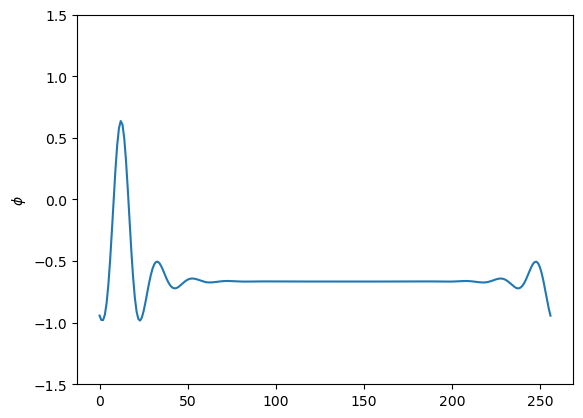

In [103]:
fig,ax = plt.subplots()
line, = ax.plot(np.arange(257),c_arrs[0])
ax.set_ylim(-1.5,1.5)
plt.ylabel(r'$\phi$')

def animate(i):
    line.set_data(np.arange(257),c_arrs[i])

from matplotlib import animation

anim = animation.FuncAnimation(fig, animate, interval=0.05, frames=total_frames-1)

anim.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\Growth\1D' + f' eps={epsilon} g={growth_factor} starting_fraction={np.round(fraction_cells,3)}' + '.mp4', writer=animation.FFMpegWriter(fps=60))


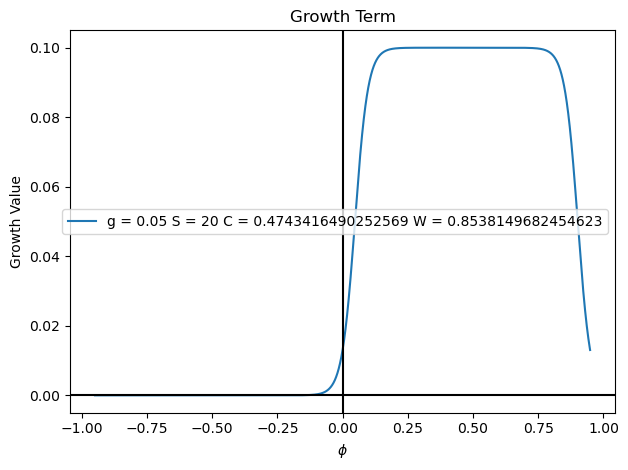

In [105]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cmath as cm
%matplotlib inline

growth = lambda g,S,C,W,x: g*(np.tanh(S*(x-C+W/2))*np.tanh(S*(-x+C+W/2)) + 1)

#Here we plot the form of the growth term


x_values_large = np.linspace(-np.sqrt(epsilon),np.sqrt(epsilon), 10000)

y_growth = growth(growth_factor,sigmoid,center,width, x_values_large)
plt.plot(x_values_large, y_growth, label = f'g = {growth_factor} S = {sigmoid} C = {center} W = {width}')
plt.title(r'Growth Term')
plt.xlabel(r'$\phi$')
plt.ylabel(r'Growth Value')
plt.legend()
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.tight_layout()
plt.savefig(f'g={growth_factor}.jpg', dpi = 800)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


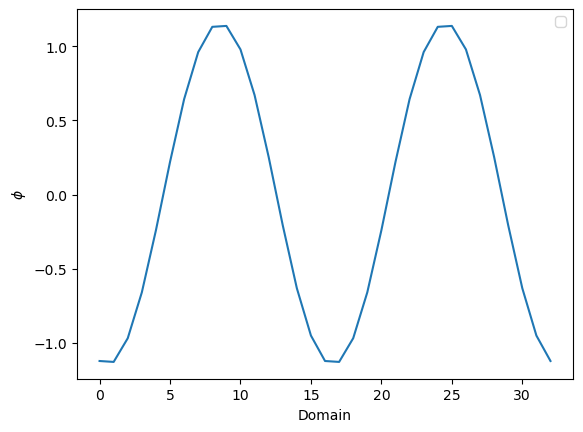

In [30]:
plt.plot(c_arr[1:-2,2])
plt.xlabel('Domain')
plt.ylabel(r'$\phi$')
plt.legend()
plt.savefig(r'1D Phase Diagram\1D eps ='+f' {epsilon}.jpg', dpi = 800)
plt.show()

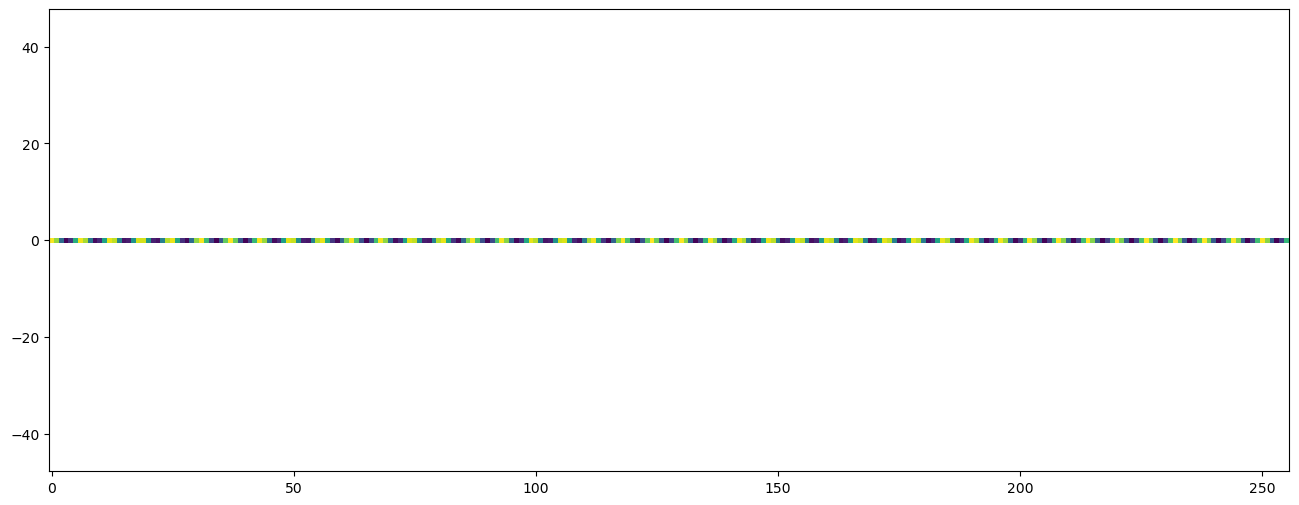

In [23]:
init(0,0.01) # initialize the system at time = 0
# run the simulation and save a video in time
ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=2500)
writervideo = animation.FFMpegWriter(fps=60)
ani.save(r'C:\Users\taylo\UU Thesis - Smectodynamics of Dividing Cells\Pystencils Videos\1Dswift-hohenberg.mp4', writer=writervideo)